## Import libraries 

# Necessary Imports

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


## Get Image

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import VGG16 and opencv2

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

# Method to get GRADCAM Image

In [0]:
def get_gradcam_image(imageInput, model, layer_name, classindex=None):
    x = image.img_to_array(img_obj)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    if classindex is not None:
        class_idx = classindex
    else:
        class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    conv_layer = model.get_layer(layer_name)


    grads = K.gradients(class_output, conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
  
    no_of_channels = conv_layer.get_weights()[0].shape[-1]
    for i in range(no_of_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

   
 #Heat Map of the image 
  
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 1e-7)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (imageInput.shape[1], imageInput.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)



    originalimage= np.uint8(imageInput)

    superimposed_img = cv2.addWeighted(originalimage, 0.5, heatmap, 0.5, 0)
    return superimposed_img

## Get Model summary



In [10]:
model = VGG16(weights="imagenet")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Load image with sunglasses and resizing the Image


In [0]:
from skimage import io
avenger_image="/content/drive/My Drive/tony_stark_avenger3_headscrupt_with_glasses.jpg"
img_obj = io.imread(avenger_image)
img_obj = cv2.resize(img_obj, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


## CI of Sunglass

In [0]:
class_idx=836

# Display GradCAM images of layer before last convolutional layer 

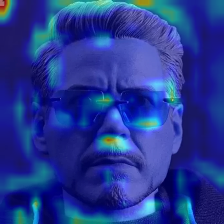

In [14]:
one_layer_before_last_conv_layer = "block4_conv1"
super_imposed_image = get_gradcam_image(img_obj, model, one_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

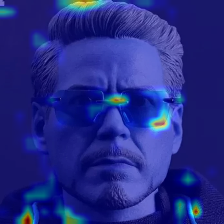

In [15]:
one_layer_before_last_conv_layer = "block4_conv2"
super_imposed_image = get_gradcam_image(img_obj, model, one_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

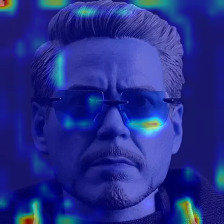

In [16]:
one_layer_before_last_conv_layer = "block4_conv3"
super_imposed_image = get_gradcam_image(img_obj, model, one_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

# Display GradCAM images of two layers before last convolutional layer 

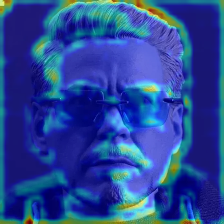

In [17]:
two_layer_before_last_conv_layer = "block3_conv1"
super_imposed_image = get_gradcam_image(img_obj, model, two_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

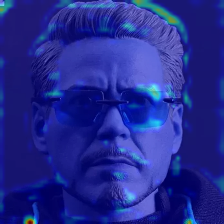

In [18]:
two_layer_before_last_conv_layer = "block3_conv2"
super_imposed_image = get_gradcam_image(img_obj, model, two_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

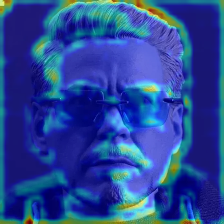

In [19]:
two_layer_before_last_conv_layer = "block3_conv1"
super_imposed_image = get_gradcam_image(img_obj, model, two_layer_before_last_conv_layer, class_idx)
from google.colab.patches import cv2_imshow
cv2_imshow(super_imposed_image)

#Assignment 10 B:-

The Paper referred for this Assignment is a CNN-based Segmentation of Medical Imaging Data.
It uses UNET Architecture.

We have referred the Table 7 of Page 21, where the Receptive field changes from 29 to 45
when a contracting path ends.


RF Layer L = RF Layer (L-1) + 2^(Number of strides - Number of Deconvolution)*(Filter Size -1)

RF for Layer 7 = 29 + 2^(3-0) *(3-1) = 29 + 8*2 = 45

That is why the receptive field of layer 7 is 45x45x45 from 29x29x29 of layer 6



